In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [111]:
def print_section(title):
    print("\n" + "="*5 + " " + title + " " + "="*5 + "\n")

In [112]:
def eval_and_print(y_true, y_pred):
    # Deteksi label unik (misal: ['No','Yes'] atau [False,True])
    unique_labels = sorted(list(set(y_true)))

    # Tentukan positive class = label terbesar (Yes atau True)
    pos = unique_labels[-1]

    # Hitung metrik
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=pos)
    rec = recall_score(y_true, y_pred, pos_label=pos)
    f1 = f1_score(y_true, y_pred, pos_label=pos)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Buat label tampilan (No/Yes), tapi tetap gunakan label asli di confusion matrix
    display_labels = ['No', 'Yes']
    
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=display_labels, yticklabels=display_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [113]:
DATA_PATH = "telechurn.csv"
df = pd.read_csv(DATA_PATH)

In [114]:
# lihat row kolom
print("Shape:", df.shape)

Shape: (7043, 21)


In [115]:
# Tampilkan 5 baris pertama
print_section("5 Baris Pertama")
display(df.head())


===== 5 Baris Pertama =====



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [116]:
# Info() ringkasan
print_section("Info() ringkasan")
print(df.info())


===== Info() ringkasan =====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBi

In [117]:
# Statistik deskriptif untuk fitur numerik
print_section("Deskriptif (numerik)")
display(df.describe())


===== Deskriptif (numerik) =====



,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [118]:
# Identifikasi missing value
print_section("Missing Values (persentase per kolom)")
missing_pct = df.isnull().mean() * 100
missing_df = missing_pct.reset_index()
missing_df.columns = ['feature', 'missing_pct']
display(missing_df.sort_values(by='missing_pct', ascending=False))


===== Missing Values (persentase per kolom) =====



,feature,missing_pct
0,customerID,0.0
11,DeviceProtection,0.0
19,TotalCharges,0.0
18,MonthlyCharges,0.0
17,PaymentMethod,0.0
16,PaperlessBilling,0.0
15,Contract,0.0
14,StreamingMovies,0.0
13,StreamingTV,0.0
12,TechSupport,0.0


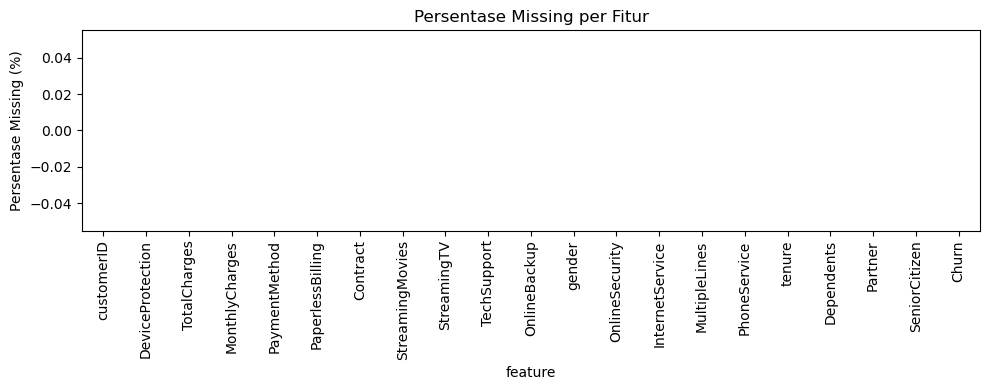

In [119]:
# Visualisasi missing value (bar chart)
plt.figure(figsize=(10,4))
sns.barplot(data=missing_df.sort_values('missing_pct', ascending=False), x='feature', y='missing_pct')
plt.xticks(rotation=90)
plt.ylabel("Persentase Missing (%)")
plt.title("Persentase Missing per Fitur")
plt.tight_layout()
plt.show()

In [120]:
# NOTE: Pada dataset Telco, kolom 'TotalCharges' kadang bertipe object dan mengandung spaces -> perlu konversi
print_section("Periksa TotalCharges unik contoh (beberapa baris)")
print(df['TotalCharges'].sample(10).values)


===== Periksa TotalCharges unik contoh (beberapa baris) =====

['210.3' '470.2' '223.15' '4914.9' '6555.2' '151.3' '1648.45' '639.65'
 '2032.3' '927.65']



===== Distribusi Target: Churn =====

Churn
No     5174
Yes    1869
Name: count, dtype: int64


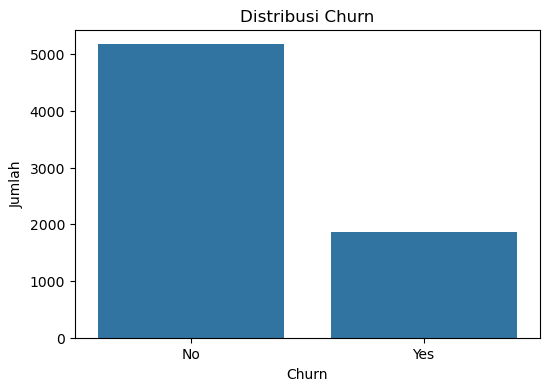

In [121]:
# Visualisasi distribusi target (Churn)
print_section("Distribusi Target: Churn")
churn_counts = df['Churn'].value_counts()
print(churn_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.title("Distribusi Churn")
plt.ylabel("Jumlah")
plt.show()

In [122]:
# Persentase
print("Persentase:")
print((churn_counts / churn_counts.sum() * 100).round(2))

Persentase:
Churn
No     73.46
Yes    26.54
Name: count, dtype: float64



===== Korelasi fitur numerik =====

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


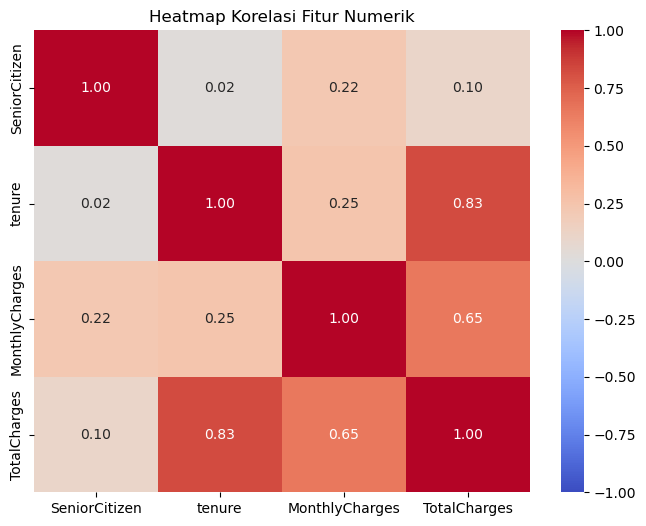

Pasangan korelasi absolut > 0.5:
tenure          TotalCharges    0.825880
MonthlyCharges  TotalCharges    0.651065
dtype: float64


In [123]:
# Korelasi fitur numerik
print_section("Korelasi fitur numerik")
# Convert possible numeric columns
# first convert TotalCharges to numeric (coerce errors)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric columns:", numeric_cols)

plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

# Identifikasi pasangan korelasi tinggi (abs > 0.5)
high_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_corr = high_corr[ (high_corr < 1) & (high_corr > 0.5) ]
print("Pasangan korelasi absolut > 0.5:")
print(high_corr)

In [124]:
# Identifikasi pasangan korelasi tinggi (abs > 0.5)
high_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_corr = high_corr[ (high_corr < 1) & (high_corr > 0.5) ]
print("Pasangan korelasi absolut > 0.5:")
print(high_corr)

Pasangan korelasi absolut > 0.5:
tenure          TotalCharges    0.825880
MonthlyCharges  TotalCharges    0.651065
dtype: float64


In [125]:
# Ubah TotalCharges menjadi numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [126]:
# Imputer global untuk kategorikal & numerik
from sklearn.impute import SimpleImputer

num_cols  = df.select_dtypes(include=['float64','int64']).columns
cat_cols  = df.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

In [127]:
# Encoding kategori
df = pd.get_dummies(df, drop_first=True)

In [128]:
# Pisahkan X dan y
X = df.drop("Churn_Yes", axis=1)
y = df["Churn_Yes"]

In [129]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Imputer (jaga-jaga)
imputer = SimpleImputer(strategy='most_frequent')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [131]:
# Pilih 3 model:
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_knn = KNeighborsClassifier()
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [132]:
models = {'LogisticRegression': model_lr, 'KNN': model_knn, 'RandomForest': model_rf}


===== Model: LogisticRegression - Training =====



C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy : 0.8098
Precision: 0.6586
Recall   : 0.5845
F1-score : 0.6193

Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.89      0.87      1036
        True       0.66      0.58      0.62       373

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.81      0.81      1409



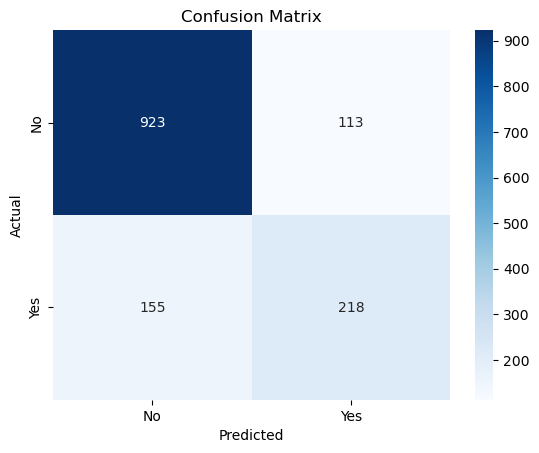


===== Model: KNN - Training =====

Accuracy : 0.7771
Precision: 0.5974
Recall   : 0.4853
F1-score : 0.5355

Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.88      0.85      1036
        True       0.60      0.49      0.54       373

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



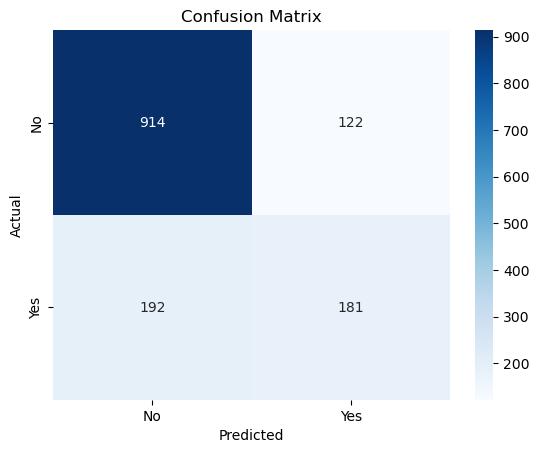


===== Model: RandomForest - Training =====

Accuracy : 0.7977
Precision: 0.6760
Recall   : 0.4531
F1-score : 0.5425

Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.92      0.87      1036
        True       0.68      0.45      0.54       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



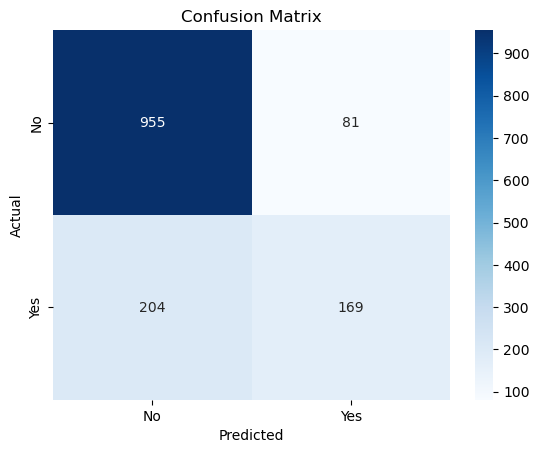

In [133]:
# Latih & evaluasi (tanpa preprocessing/tuning)
for name, m in models.items():
    print_section(f"Model: {name} - Training")
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    eval_and_print(y_test, preds)

In [134]:
# sesudah preprocessing

In [135]:
# Hapus duplikasi
df_pp = df.copy()
before_dup = df_pp.shape[0]
df_pp = df_pp.drop_duplicates()
after_dup = df_pp.shape[0]
print(f"Duplikasi dihapus: {before_dup - after_dup} baris")

Duplikasi dihapus: 0 baris


In [136]:
# Tangani missing di TotalCharges: isi dengan median
print("Missing TotalCharges sebelum:", df_pp['TotalCharges'].isna().sum())
df_pp['TotalCharges'] = df_pp['TotalCharges'].fillna(df_pp['TotalCharges'].median())
print("Missing TotalCharges setelah:", df_pp['TotalCharges'].isna().sum())

Missing TotalCharges sebelum: 0
Missing TotalCharges setelah: 0


In [137]:
# Pilah fitur numerik dan kategorikal
numeric_features = ['tenure','MonthlyCharges','TotalCharges']
# semua selain customerID dan Churn dan numerik di atas -> kategorikal
categorical_features = [c for c in df_pp.columns if c not in numeric_features + ['customerID','Churn']]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features[:10], " ... total:", len(categorical_features))

# Buat ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Untuk kategorikal gunakan OneHotEncoder (drop='first' untuk menghindari multikolinearitas)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['SeniorCitizen', 'customerID_0003-MKNFE', 'customerID_0004-TLHLJ', 'customerID_0011-IGKFF', 'customerID_0013-EXCHZ', 'customerID_0013-MHZWF', 'customerID_0013-SMEOE', 'customerID_0014-BMAQU', 'customerID_0015-UOCOJ', 'customerID_0016-QLJIS']  ... total: 7070


In [138]:
# Siapkan X,y setelah preprocessing pipeline (di-pipeline-kan bersama model)
X_pp = df_pp.drop(columns=['customerID','Churn'])
y_pp = df_pp['Churn']

KeyError: "['customerID', 'Churn'] not found in axis"